<a href="https://colab.research.google.com/github/art-glazunov/MegaFon_RecSys_Workshop/blob/main/Part_5_Two_levels_hybrid_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MegaFon RecSys workshop
by Artyom Glazunov

## Part 5. Two-levels hybrid recommender with LightFM and CatBoost libraries

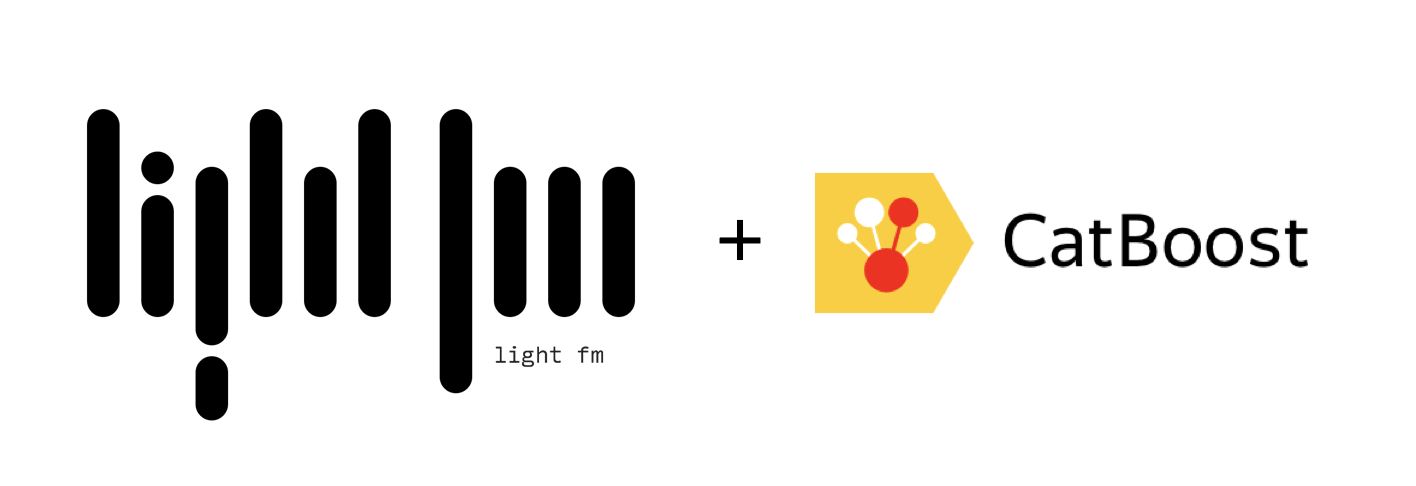

## The plan

- ### Data loading
- ### The scheme of the process
- ### Useful classes and methods
- ### The first level model training
- ### The second level model training
- ### Evaluation
- ### Features importances picture

In [ ]:
pip install -q lightfm==1.16

     |████████████████████████████████| 310 kB 5.8 MB/s 


In [ ]:
pip install -q catboost

     |████████████████████████████████| 76.6 MB 84 kB/s 


In [ ]:
pip install -q shap

     |████████████████████████████████| 564 kB 4.8 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import scipy

import sklearn
from sklearn.base import TransformerMixin, BaseEstimator
import lightfm
from lightfm import data
from catboost import CatBoostClassifier

from sklearn.metrics import roc_auc_score

from matplotlib import pyplot as plt
import shap

### Data loading

In [ ]:
cd /content/drive/MyDrive/Colab_Notebooks/datafest_22/data

/content/drive/MyDrive/Colab_Notebooks/datafest_22/data


In [ ]:
data_train_all = pd.read_csv("train.csv")
data_val = pd.read_csv("validation.csv")
data_test = pd.read_csv("test.csv")
cold_users_data = pd.read_csv("cold_users_data.csv")
cold_items_data = pd.read_csv("cold_items_data.csv")

In [ ]:
data_train_all.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date
0,xvCGZ5McgEJlkYx2HNO1/CkD1CYjlA/gQL36iX8TYBY=,868uXMrBS8WwQulNX0W+vk6sJA6Hs35YNtFYceXgX/I=,radio,Radio,radio,0,255373.0,465,張震嶽,NaN,NaN,3.0,勇氣,TWA450479802,1,0,NaN,7,2013-05-14,2017-09-24
1,jOlB9i8NKGG2oudUKq9ObRyt3sXQnWWwcei1+s8sNIA=,a4TbK5V15pj3YZUOGa9h2U3t0OsE+3aiFw41mNlcgcw=,my library,Local playlist more,local-library,1,248790.0,465,吳汶芳 (Fang Wu),吳汶芳,吳汶芳,3.0,孤獨的總和 (Accumulated Loneliness),TWA211328806,13,31,female,9,2011-04-19,2017-06-20
2,fe+6batTKL/NxXhhzfDO3yBUmFmQUQAgRpYmF2T0t4E=,5RLsVkl6PTt3pIyWvojM0z2LblVysXHxoc7Mc4LIFL8=,my library,Local playlist more,local-library,1,178887.0,921,Noel Coward,NaN,NaN,52.0,Poor Little Rich Girl,USV291338277,5,33,female,9,2008-08-05,2017-10-06
3,GVcP7SPQ/IgiEt2uxaXaRH5lFA5tBe8T74/Etk7cnG8=,7Xxzo9Z584Z1AhkaLLWEcpzcEuxcquGE52Ztc4879YI=,discover,Online playlist more,online-playlist,1,275136.0,465,田馥甄 (Hebe),楊子樸,施人誠,3.0,寂寞寂寞就好,TWD951043107,1,0,NaN,7,2011-02-25,2017-09-12
4,XIfoYUt6vkAqVDRKJRVEHkV0jsaD+fif2EqxsobpEqg=,rA+H/y66yC2qK0v926aWRFWngwJmL+IhGhJN4fBS0XM=,radio,Radio,radio,0,243983.0,465,范瑋琪 (Christine Fan),陳小霞,姚若龍,3.0,最重要的決定,TWA211125202,5,22,female,7,2013-07-29,2017-09-30


### The scheme of the process:

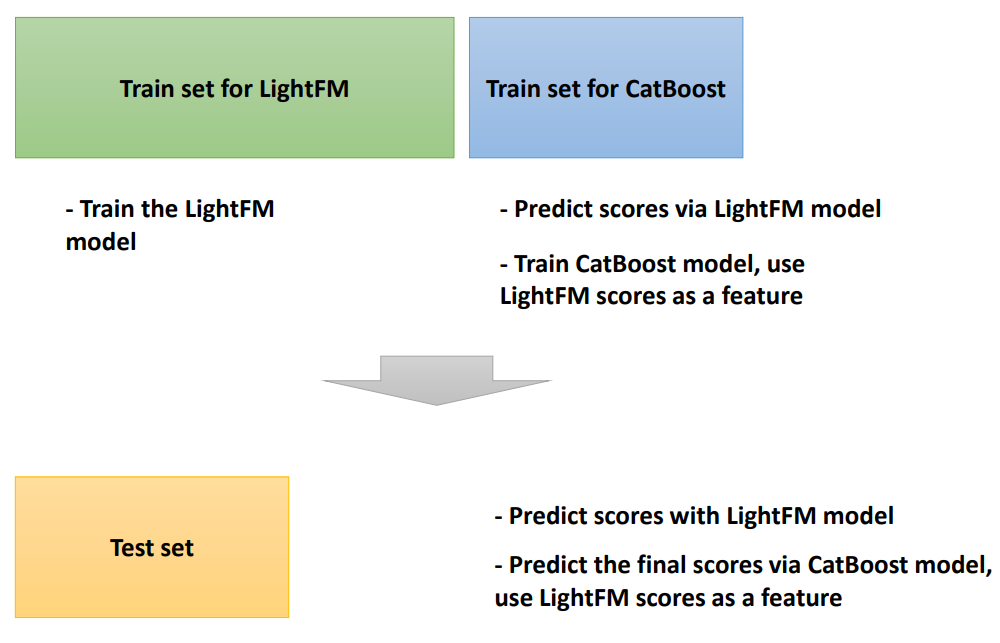

### Let's split the train dataset into two parts - one for lightfm and the second - for catboost

In [ ]:
lfm_train_limit = int(data_train_all.shape[0] * 0.85)
data_train_lfm_all = data_train_all.iloc[:lfm_train_limit]
data_train_lfm_pos = data_train_lfm_all[data_train_lfm_all.target == 1]
data_train_cb = data_train_all.iloc[lfm_train_limit:]

In [ ]:
data_train_all.shape, data_train_lfm_pos.shape, data_train_cb.shape, data_val.shape, data_test.shape, cold_users_data.shape, cold_items_data.shape

((5046332, 20),
 (2158927, 20),
 (756950, 20),
 (630792, 20),
 (630792, 20),
 (715482, 20),
 (392174, 20))

### Useful classes and methods

In [ ]:
class ColumnCategorizer(TransformerMixin, BaseEstimator):
    """Creates new categorical features using continuous columns
    
    Requires 
    - quantiles list
    - columns to transform
    - new columns names
    """
    

    def __init__(self, qs, new_columns, old_columns):
        self.qs = qs #quantile list
        self.new_columns = new_columns #columns to create
        self.old_columns = old_columns #initial continuous columns
        self.transformers = {} #transformers storage
        

    def fit(self, X, y=None):
        """Fit transformers on a part of the columns
        X - train data
        """
        
        for column in self.old_columns:
            bins = np.unique([X[column].quantile(q=q) for q in self.qs])
            labels = [f"{column}_bin_{l_edge}_{r_edge}" for (l_edge, r_edge) in zip(bins[:-1], bins[1:])]
            self.transformers[column] = sklearn.preprocessing.FunctionTransformer(
                                             pd.cut, kw_args={'bins': bins, 
                                                              'include_lowest': True,
                                                              'labels': labels, 
                                                              'retbins': False}
                                                              ) 
            self.transformers[column].fit(X[column])
        return self
    

    def transform(self, X):
        """Transform data and return Pandas DataFrame
        X - data to transform
        """
        
        data_new = X.copy()
        for column_old, column_new in zip(self.old_columns, self.new_columns):
            data_new[column_new] = self.transformers[column_old].transform(data_new[column_old]).values
        return data_new


def names_to_cats(data_to_transform, cols):
    """Transform numeric categories using names of features
    
    data_to_transform - data to transform
    cols - columns to change
    """


    data_new = data_to_transform.copy()
    for col in cols:
        data_new[col] = data_new[col].apply(lambda x: f"{col}_{x}").values
    return data_new


def to_categorical(X, cat_cols = []):
    """Make categorical columns be of type "str"
    """
    
    X_new = X.copy()
    for col in cat_cols:
        X_new.loc[:, col] = X_new[col].astype(str).values
    return X_new

In [ ]:
def get_mappings(dataset):
    """Prepare the mappings

    dataset - lightfm dataset object
    """
    result_dict = {}
    result_dict["user_id_mapping"] = dataset.mapping()[0]
    result_dict["item_id_mapping"] = dataset.mapping()[2]
    result_dict["user_fename_intid_mapping"] = dataset._user_feature_mapping
    result_dict["item_fename_intid_mapping"] = dataset._item_feature_mapping
    return result_dict


def get_cold_weights(data_val, fename_intid_mapping):
    """Get weights for COLD users/items

    data_val - our data with features
    fename_intid_mapping - mapping with ids and category names
    """

    row_ids = []
    col_ids = []
    for ind_r, features in enumerate(data_val.values):
        for cat_name in features:
            if cat_name in fename_intid_mapping:
                row_ids.append(ind_r)
                col_ids.append(fename_intid_mapping[cat_name])
    values = [1] * len(col_ids)

    result = sklearn.preprocessing.\
                      normalize(scipy.sparse.csr.\
                                csr_matrix((values, (row_ids, col_ids)),
                                            shape = (data_val.shape[0],
                                                    len(fename_intid_mapping))),
                                norm="l1", copy=False)
    return result


def get_id_weights_mapping(data_val, selected_cols, id_col, 
                           id_mapping, fename_intid_mapping, 
                           train_weights):
    """Get mapping with ids as keys
    and light fm sparse weights as values

    Brings hot and cold data and computes the weights matrix
    data_val - our data
    selected cols - column names WITH id column 
    id_col - user/item id column
    id_mapping - light fm external-internal id mapping
    fename_intid_mapping - mapping with ids and category names
    train_weights - weights from the train time (created via dataset object)
    """

    ids_set = data_val[id_col].unique()

    id_weights_mapping = {}
    cold_ids = []
    for ind in ids_set:
        if ind in id_mapping:
            id_weights_mapping[ind] = train_weights[id_mapping[ind]]
        else:
            cold_ids.append(ind)

    if len(cold_ids) > 0:
        data_select = data_val[selected_cols]
        data_cold = data_select[data_select[id_col].isin(cold_ids)].drop_duplicates()
        cold_weights = get_cold_weights(data_cold, fename_intid_mapping) 
        for ind, cold_entity in enumerate(data_cold[id_col]):
            id_weights_mapping[cold_entity] = cold_weights[ind]

    return id_weights_mapping


def get_lightfm_weights_tables_v2(data_val, user_id_col, item_id_col, 
                                  user_id_weights_mapping, 
                                  item_id_weights_mapping):
    """Prepare normalized OHE sparse matrices
    Considers both HOT and COLD users/items

    data_val - our data with features
    user_id_col - users id column
    item_id_col - item id column
    user_fename_intid_mapping, item_fename_intid_mapping - mappings
    """

    result_user = []
    result_item = []
    for user_ind, item_ind in zip(data_val[user_id_col], data_val[item_id_col]):
        result_user.append(user_id_weights_mapping[user_ind])
        result_item.append(item_id_weights_mapping[item_ind])

    return scipy.sparse.vstack(result_user), scipy.sparse.vstack(result_item)


def get_result_df(data_val, result_cols, scores):
    """Get resulting dataframe

    data_val - initial data with features
    result_cols - columns without scores (ids, other useful info)
    scores - predicted scores
    """
    
    real_pred_df = data_val[result_cols].copy()
    real_pred_df['score'] = scores
    return real_pred_df


def users_roc_auc_scores(real_pred_data, id_col="msno", 
                         target_col="target", score_col="score"):
    """Compute ROC AUC scores
    for users

    real_pred_data - data with target and score
    id_col - user_id column
    target_col, score_col - columns with target values and model's scores
    """

    roc_auc_scores = []
    for _, data_us in real_pred_data.groupby(id_col):
        roc_auc_scores.append(roc_auc_score(data_us[target_col], data_us[score_col]))
    return roc_auc_scores


def users_rr_scores(real_pred_data, id_col="msno", 
        target_col="target", score_col="score"):
    """Compute RR scores for users

    real_pred_data - data with target and score
    id_col - user_id column
    target_col, score_col - columns with target values and model's scores
    """

    rr_scores = []
    for _, data_us in real_pred_data.groupby(id_col):
        data_us_sorted = data_us.sort_values(by=[score_col], ascending=False)\
                                .reset_index(drop=True)
        rr_score = 1 / ((data_us_sorted.target == 1).argmax() + 1)
        rr_scores.append(rr_score)
    return rr_scores


def precision_at_k(real_pred_data, k=5, id_col="msno", 
        target_col="target", score_col="score"):
    """Compute precision@k scores for users

    real_pred_data - data with target and score
    k - size of the top 
    id_col- user_id column
    target_col, score_col - columns with target values and model's scores
    """

    precision_scores = []
    for _, data_us in real_pred_data.groupby(id_col):
        data_us_sorted = data_us.sort_values(by=[score_col], ascending=False)
        precision_score = data_us_sorted.iloc[:k].target.sum() / k
        precision_scores.append(precision_score)
    return precision_scores

In [ ]:
def lfm_train_preprocessing(data_train, 
                            categorizer,
                            cat_cols_to_change,
                            user_fe_cols,
                            item_fe_cols,
                            user_id_column,
                            item_id_column,
                            user_identity_features=True,
                            item_identity_features=True):
    """Get all the object needed for the lfm model training

    data_train - train_data
    categorizer - numeric columns categorizer object
    cat_cols_to_change - columns to change via names_to_cats() method
    user_fe_cols - user features columns WITHOUT the id columns
    item_fe_cols - item features columns WITHOUT the id columns
    user_id_column - user id column
    item_id_column - item id column
    user_identity_features - consider user id as a feature?
    item_identity_features - consider item id as a feature?
    """

    data_prep = categorizer.transform(names_to_cats(data_train, cat_cols_to_change))

    user_fe_data = data_prep[user_fe_cols].values
    item_fe_data = data_prep[item_fe_cols].values
    user_id = data_prep[user_id_column].values.ravel()
    item_id = data_prep[item_id_column].values.ravel()


    dataset = data.Dataset(user_identity_features=user_identity_features,
                           item_identity_features=item_identity_features)
    dataset.fit(users=user_id, items=item_id,
                user_features=user_fe_data.ravel(),
                item_features=item_fe_data.ravel())
    user_features = dataset.build_user_features(((x[0], x[1]) for x \
                                                    in zip(user_id, user_fe_data)))
    item_features = dataset.build_item_features(((x[0], x[1]) for x \
                                                    in zip(item_id, item_fe_data)))
    interactions, _ = dataset.build_interactions(((x[0], x[1]) for x \
                                                    in zip(user_id, item_id)))
    result = {"dataset" : dataset,
              "user_features": user_features,
              "item_features": item_features,
              "interactions": interactions}
    return result


def test_data_preprocessing(data_test, id="msno", k=10, 
                            min_prop=0.05, max_prop=0.95):
    """Pick only users 
    with both positive and negative responces

    data_test - data to transform
    id - user id column name
    k - minimum number of songs that a user interacted with
    min/max_prop - minimum/maximum limits for the proportion of 
        positive interactions in users histories
    """

    data_new = data_test.copy()
    val_users = []
    for user_id, data_us in data_new.groupby([id]):
        pos_cnt = data_us.target.sum()
        cnt = data_us.shape[0]
        pos_prop = pos_cnt / cnt
        if cnt >= k and pos_prop > min_prop and pos_prop < max_prop:
            val_users.append(user_id)    

    data_prep = data_new[data_new[id].isin(val_users)].reset_index(drop=True)
    return data_prep


def lfm_test_preprocessing_v2(data_val, lfm_dataset,
                              categorizer,
                              k, cat_cols_to_change,
                              user_fe_cols,
                              item_fe_cols,
                              user_id_column,
                              item_id_column,
                              train_user_weights,
                              train_item_weights,
                              k_filter=True,
                              min_prop=0.05, max_prop=0.95):
    """Get all the objects needed for getting model's scores


    data_val - test data
    lfm_dataset - lightfm dataset object
    categorizer - numeric columns categorizer object
    k - test_data_preprocessing() method parameter (minumum user's history size)
    cat_cols_to_change - columns to change via names_to_cats() method
    user_fe_cols - user features columns WITHOUT the id columns
    item_fe_cols - item features columns WITHOUT the id columns
    user_id_column - user id column
    item_id_column - item id column
    train_user_weights - matrix from dataset.build_user_features() 
        method before the training
    train_item_weights - matrix from dataset.build_item_features() 
        method before the training
    k_filter - a flag for the initial data filtration via test_data_preprocessing
    min/max_prop - minimum/maximum limits for the proportion of 
        positive interactions in users histories
    """
  
  
    if k_filter:
        data_val = test_data_preprocessing(data_val, id=user_id_column, k=k,
                                           min_prop=min_prop, max_prop=max_prop)
    data_prep = categorizer.transform(names_to_cats(data_val, 
                                                    cat_cols_to_change))

    mappings = get_mappings(lfm_dataset)
    user_id_mapping = mappings["user_id_mapping"]
    item_id_mapping = mappings["item_id_mapping"]
    user_fename_intid_mapping = mappings["user_fename_intid_mapping"]
    item_fename_intid_mapping = mappings["item_fename_intid_mapping"]


    user_cols = [user_id_column] + user_fe_cols
    item_cols = [item_id_column] + item_fe_cols

    user_id_weights_mapping = get_id_weights_mapping(data_prep, 
                                                     selected_cols=user_cols,
                                                     id_col=user_id_column, 
                                                     id_mapping=user_id_mapping, 
                                                     fename_intid_mapping=user_fename_intid_mapping, 
                                                     train_weights=train_user_weights)
    item_id_weights_mapping = get_id_weights_mapping(data_prep, 
                                                     selected_cols=item_cols,
                                                     id_col=item_id_column, 
                                                     id_mapping=item_id_mapping, 
                                                     fename_intid_mapping=item_fename_intid_mapping, 
                                                     train_weights=train_item_weights)
    u_weights, i_weights = get_lightfm_weights_tables_v2(data_prep, 
                                                         user_id_column, item_id_column,
                                                         user_id_weights_mapping, 
                                                         item_id_weights_mapping)
    ids = np.array(list(range(u_weights.shape[0])))

    result_dict = {"data_prep": data_prep,
                   "ids": ids,
                   "u_weights": u_weights,
                   "i_weights": i_weights}
    return result_dict


def get_lfm_scores_df(lfm_model, data_in,
                      lfm_dataset,
                      categorizer,
                      train_user_weights,
                      train_item_weights,
                      cat_cols_to_change,
                      user_fe_cols,
                      item_fe_cols,
                      user_id_column,
                      item_id_column,
                      num_threads=4):
    """Get resulting DataFrame object with added score column. 
    We can use this method for the second level model data preparation

    data_in - initial data to transform
    lfm_model - trained lightfm model
    lfm_dataset - lightfm dataset object
    categorizer - numeric columns categorizer object
    train_user_weights - matrix from dataset.build_user_features() 
        method before the training
    train_item_weights - matrix from dataset.build_item_features() 
        method before the training
    cat_cols_to_change - columns to change via names_to_cats() method
    user_fe_cols - user features columns WITHOUT the id columns
    item_fe_cols - item features columns WITHOUT the id columns
    user_id_column - user id column
    item_id_column - item id column
    num_threads - parameter to use parallels
    """
    
    k = None
    result_dict = lfm_test_preprocessing_v2(data_in, lfm_dataset,
                                            categorizer,
                                            k, cat_cols_to_change,
                                            user_fe_cols,
                                            item_fe_cols,
                                            user_id_column,
                                            item_id_column,
                                            train_user_weights,
                                            train_item_weights,
                                            k_filter=False)

    ids = result_dict['ids']
    u_weights = result_dict['u_weights']
    i_weights = result_dict['i_weights']
    
    user_items_scores = lfm_model.predict(user_ids=ids,
                                          user_features=u_weights,
                                          item_ids=ids,
                                          item_features=i_weights,
                                          num_threads=num_threads)
    data_ext = data_in.copy()
    data_ext["lfm_score"] = user_items_scores
    return data_ext


def two_level_evaluation(lfm_model,
                         categorizer, rec_head,
                         data_val, rec_head_features,
                         rec_head_cat_cols,
                         result_cols, 
                         lfm_dataset,
                         train_user_weights,
                         train_item_weights,
                         n, cat_cols_to_change,
                         user_fe_cols,
                         item_fe_cols,
                         user_id_column,
                         item_id_column,
                         k=5,
                         num_threads=4,
                         min_prop=0.05, max_prop=0.95):
    """Two-levels recommender model evaluation function

    lfm_model - lightfm model
    categorizer - numeric columns categorizer object
    rec_head - the second level ranker/clf model (here we use catboost clf)
    data_val - validation dataframe
    rec_head_features - features list for the second level model
    rec_head_cat_cols - rec_head categorical features
    result_cols - columns in the resulting dataframe (without score column)
    lfm_dataset - lightfm dataset object
    train_user_weights - matrix from dataset.build_user_features() 
        method before the training
    train_item_weights - matrix from dataset.build_item_features() 
        method before the training
    n - test_data_preprocessing() method parameter (here k_filter==True)
    cat_cols_to_change - columns to change via names_to_cats() method
    user_fe_cols - user features columns WITHOUT the id columns
    item_fe_cols - item features columns WITHOUT the id columns
    user_id_column - user id column
    item_id_column - item id column
    k - precision_at_k() method parameter
    num_threads - num threads for parallelization of calculations
    min/max_prop - minimum/maximum limits for the proportion of 
        positive interactions in users histories
    """


    result_dict = lfm_test_preprocessing_v2(data_val, lfm_dataset,
                                            categorizer,
                                            n, cat_cols_to_change,
                                            user_fe_cols,
                                            item_fe_cols,
                                            user_id_column,
                                            item_id_column,
                                            train_user_weights,
                                            train_item_weights,
                                            min_prop=min_prop, max_prop=max_prop)
    u_weights, i_weights, ids, data_prep = result_dict['u_weights'], result_dict['i_weights'], \
                                           result_dict['ids'], result_dict['data_prep'] 
    lfm_user_items_scores = lfm_model.predict(user_ids=ids,
                                              user_features=u_weights,
                                              item_ids=ids,
                                              item_features=i_weights,
                                              num_threads=num_threads)
    data_val_ext = test_data_preprocessing(data_val, id=user_id_column, k=n,
                                           min_prop=min_prop, max_prop=max_prop)
    data_val_ext["lfm_score"] = lfm_user_items_scores

    X_val_cb = to_categorical(data_val_ext[rec_head_features], 
                              cat_cols=rec_head_cat_cols)
    fin_user_items_scores = rec_head.predict_proba(X_val_cb)[:, 1]

    val_real_pred = get_result_df(data_val_ext, result_cols, fin_user_items_scores)
    roc_auc_scores = users_roc_auc_scores(val_real_pred)
    rr_scores = users_rr_scores(val_real_pred)
    p_at_k_scores = precision_at_k(val_real_pred, k=k)
    print(f"Users mean AUC ROC on test: {np.mean(roc_auc_scores)}")
    print(f"Users mean reciprocal rank on test: {np.mean(rr_scores)}")
    print(f"Users mean precision@{k} on test: {np.mean(p_at_k_scores)}")
    plt.figure()
    plt.hist(roc_auc_scores)
    plt.title("USERS AUC ROC SCORES")
    plt.grid()
    plt.figure()
    plt.hist(rr_scores)
    plt.title(f"USERS RECIPROCAL RANK SCORES")
    plt.grid()
    plt.figure()
    plt.hist(p_at_k_scores)
    plt.title(f"USERS PRECISION@{k} SCORES")
    plt.grid()
    return val_real_pred

### Train the first level model

In [ ]:
# Assign lists of features for training the lightfm dataset object
user_fe_cols = []
item_fe_cols = ["genre_ids", "artist_name", "composer", "language"]
user_id_column = "msno"
item_id_column = "song_id"

#Other lists of features
cat_cols_to_change = ["genre_ids", "language"] #columns to add name to value
numeric_cols = [] #this columns will be categorized

#Columns in the result dataframe
result_cols = [user_id_column, item_id_column, "target"]

In [ ]:
#####
#quantile list for categorization
QS = np.linspace(0, 1, 11, endpoint=True)
#####

#Here, only for the interface, empty object
categorizer = ColumnCategorizer(qs=QS, 
                                new_columns=numeric_cols, 
                                old_columns=numeric_cols)
categorizer.fit(data_train_lfm_all)

ColumnCategorizer(new_columns=[], old_columns=[],
                  qs=array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [ ]:
%%time
prep_dict = lfm_train_preprocessing(data_train_lfm_pos,
                                    categorizer=categorizer,
                                    cat_cols_to_change=cat_cols_to_change,
                                    user_fe_cols=user_fe_cols,
                                    item_fe_cols=item_fe_cols,
                                    user_id_column=user_id_column,
                                    item_id_column=item_id_column,
                                    user_identity_features=True,
                                    item_identity_features=False)
dataset = prep_dict["dataset"]
interactions = prep_dict["interactions"]
user_features = prep_dict["user_features"]
item_features = prep_dict["item_features"]

CPU times: user 36.8 s, sys: 674 ms, total: 37.4 s
Wall time: 38 s


Number of colab cores

In [ ]:
!nproc --all

2


In [ ]:
%%time
#####
EPOCH_NUM = 30
NUM_THREADS = 4 #Number of colab cores
model_params = {"loss": "warp",
                "random_state": 0,
                "no_components": 200}
#####

lfm_model = lightfm.LightFM(**model_params)
for epoch in range(0, EPOCH_NUM):
    print(f"Epoch: {epoch}")
    lfm_model.fit_partial(interactions=interactions,
                        user_features=user_features,
                        item_features=item_features,
                        num_threads=NUM_THREADS)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
CPU times: user 32min 14s, sys: 2.85 s, total: 32min 17s
Wall time: 16min 50s


### Get light fm scores from the first level model to train the second level model.

In [ ]:
%%time
data_train_cb_ext = get_lfm_scores_df(lfm_model, data_in=data_train_cb,
                                      lfm_dataset=dataset,
                                      categorizer=categorizer,
                                      train_user_weights=user_features,
                                      train_item_weights=item_features,
                                      cat_cols_to_change=cat_cols_to_change,
                                      user_fe_cols=user_fe_cols,
                                      item_fe_cols=item_fe_cols,
                                      user_id_column=user_id_column,
                                      item_id_column=item_id_column)

CPU times: user 49.4 s, sys: 2.76 s, total: 52.2 s
Wall time: 48.1 s


In [ ]:
data_train_cb_ext.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date,lfm_score
4289382,niUSujn6samMwjp40Ts7TVgjPLOYf1Lub7+jt4QcnAc=,Ujt3R5hAe0Pix2mURuC+CO6aazhCvEU2lByPzy3E90k=,discover,Unknown,online-playlist,1,234893.0,458,李玟 (CoCo Lee),Victor劉偉德 /FinLee李華章,...,3.0,18,HKH831700001,1,0,NaN,7,2010-09-23,2017-09-24,4.376373
4289383,rgs7ofqrZf/YcqRxB3R4lzhfWBE7jKbq/Vs1jlmThUk=,x+wwBWqNXLShElFWaLs1ahI15dN4cl4ShC1/Wm4PsH4=,my library,Local playlist more,local-playlist,1,273345.0,465,李榮浩,李榮浩,...,3.0,李白,CNA231302848,18,41,male,9,2010-04-18,2018-06-01,2.722195
4289384,3JH+AJdVYPFWbdJq7zUoA24+0fuEmDBnKdaeqqPqsbg=,o9HWMBZMeIPnYEpSuscGoORKE44sj3BYOdvGuIi0P68=,radio,Radio,radio,0,309394.0,458,Eric 周興哲,Eric周興哲,...,3.0,愛在身邊 (Unbreakable Love),TWA471701001,5,32,NaN,4,2015-11-05,2017-09-27,1.487631
4289385,HpW7TRq7KRk1K5pqQtmyeLsBWNUj35tKVV3ccG5bQUg=,5TKFWT9ivwAJiqRWz5apDsePXcJZ2b1RA/1gxTm6XoQ=,listen with,Others profile more,listen-with,1,259526.0,465,李佳薇 (Jess Lee),Li Si Song,...,3.0,鍊愛 (Chain Of Love),TWA531674103,15,32,female,9,2005-12-02,2017-07-10,1.658502
4289386,bqZ3SfEJTTVgnlL8EDtiMFkoOIwjxFUkpy4HuaJj2+I=,okqsKzTTt/SWk5yaScIKriCASMNt9I850NwngztAMfI=,search,Album more,album,1,210128.0,458,周湯豪 (NICKTHEREAL),周湯豪\梁永泰,...,3.0,Be Mine,TWAG11600302,1,0,NaN,7,2016-08-17,2017-09-17,-1.007358


In [ ]:
%%time
features = ["city", "gender", "bd", "registered_via", "song_length", "genre_ids", "artist_name", "composer", "language", "source_type", "lfm_score"]
cat_columns = ["city", "registered_via", "gender", "genre_ids", "artist_name", "composer", "language", "source_type"]
X_train_cb = to_categorical(data_train_cb_ext[features], 
                            cat_cols=cat_columns)
y_train_cb = data_train_cb_ext.target

rec_head = CatBoostClassifier(random_state=42, cat_features=cat_columns, 
                              task_type="GPU", verbose=False)
rec_head.fit(X_train_cb, y_train_cb)

CPU times: user 3min 48s, sys: 16.1 s, total: 4min 4s
Wall time: 3min 35s


### Evaluation

### Let's see the results

----------
Validation data
----------
Users mean AUC ROC on test: 0.6585883066870231
Users mean reciprocal rank on test: 0.8876522723723254
Users mean precision@5 on test: 0.7477744807121661


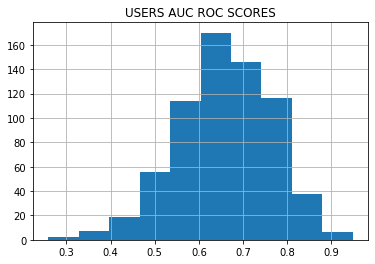

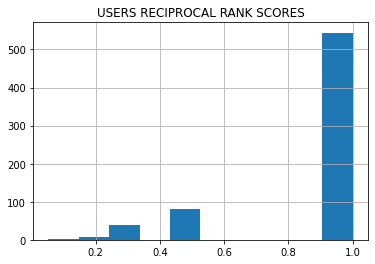

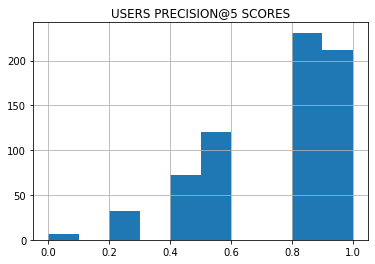

In [ ]:
#####
K = 100
MIN_PROP = 0.25
MAX_PROP = 0.75
#####

print("----------")
print("Validation data")
print("----------")
val_real_pred = two_level_evaluation(lfm_model=lfm_model, 
                                     categorizer=categorizer,
                                     rec_head=rec_head,
                                     data_val=data_val, rec_head_features=features,
                                     rec_head_cat_cols=cat_columns,
                                     result_cols=result_cols, 
                                     lfm_dataset=dataset,
                                     n=K, cat_cols_to_change=cat_cols_to_change,
                                     user_fe_cols=user_fe_cols,
                                     item_fe_cols=item_fe_cols,
                                     user_id_column=user_id_column,
                                     item_id_column=item_id_column,
                                     train_user_weights=user_features,
                                     train_item_weights=item_features,
                                     min_prop=MIN_PROP, max_prop=MAX_PROP)

In [ ]:
val_real_pred.head()

,msno,song_id,target,score
0,BGo4Oilb0i8FCeZOLUPIFGkW3RWDwNuMoixfq+Mmekk=,6DacXyIfstje6EynOjN4eLKbp95UWPZ0N+8EctMV5bw=,0,0.196172
1,y+rCSbVwnDOFjVwVE2s0m6oMKuTdift2dczOFoCUls8=,DpMV43WD2Ev8pT8uIcVrfw0tqU4r/T7RQuBhgelYefA=,0,0.288586
2,nIbXtHhahnJnRyA8FjlOQDlCJ9HGVCds8PGG9oMsf6I=,t+IofZpz3Fa/kh9rA1huUtyeJITnrToaH35PdyQUzcw=,1,0.679893
3,YMK9IDA6yFUBJxwm1SxYNM6nFrMcDAXunV/8dzGFdlo=,D1tFsBLd9VWbonfb6Vek0BI2EJB6udLOuV/x+ptYpOI=,0,0.496063
4,w4SNbHDAMuMbulkgcHGYOl/datijVua3CR5D73DylLs=,7vGvrf5l1XzNbeLZXzQgaNvc2VBmncarpN3LQpLUZiY=,1,0.513903


----------
Test data
----------
Users mean AUC ROC on test: 0.6580764215936208
Users mean reciprocal rank on test: 0.8613321575543798
Users mean precision@5 on test: 0.7395555555555556


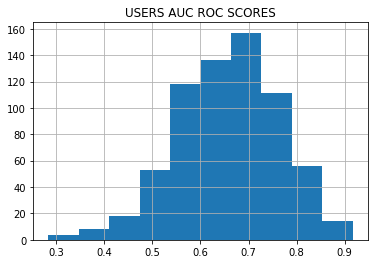

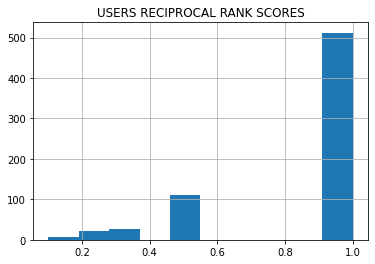

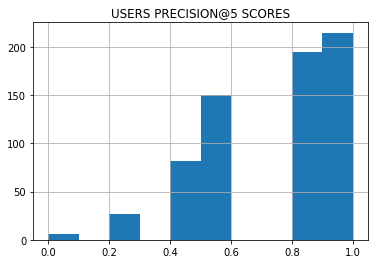

In [ ]:
#####
K = 100
MIN_PROP = 0.25
MAX_PROP = 0.75
#####

print("----------")
print("Test data")
print("----------")
_ = two_level_evaluation(lfm_model=lfm_model, 
                         categorizer=categorizer,
                         rec_head=rec_head,
                         data_val=data_test, rec_head_features=features,
                         rec_head_cat_cols=cat_columns,
                         result_cols=result_cols, 
                         lfm_dataset=dataset,
                         n=K, cat_cols_to_change=cat_cols_to_change,
                         user_fe_cols=user_fe_cols,
                         item_fe_cols=item_fe_cols,
                         user_id_column=user_id_column,
                         item_id_column=item_id_column,
                         train_user_weights=user_features,
                         train_item_weights=item_features,
                         min_prop=MIN_PROP, max_prop=MAX_PROP)

----------
Cold users data
----------
Users mean AUC ROC on test: 0.655275931105715
Users mean reciprocal rank on test: 0.8688830995128706
Users mean precision@5 on test: 0.7537404580152671


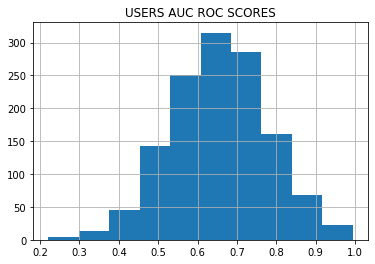

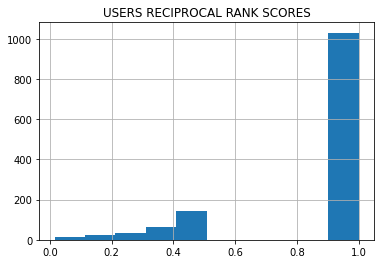

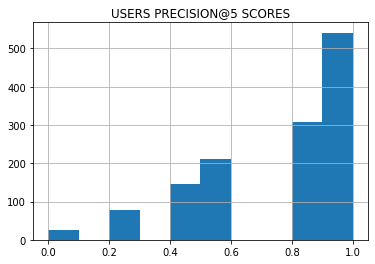

In [ ]:
#####
K = 100
MIN_PROP = 0.25
MAX_PROP = 0.75
#####

print("----------")
print("Cold users data")
print("----------")
_ = two_level_evaluation(lfm_model=lfm_model, 
                         categorizer=categorizer,rec_head=rec_head,
                         data_val=cold_users_data, rec_head_features=features,
                         rec_head_cat_cols=cat_columns,
                         result_cols=result_cols, 
                         lfm_dataset=dataset,
                         n=K, cat_cols_to_change=cat_cols_to_change,
                         user_fe_cols=user_fe_cols,
                         item_fe_cols=item_fe_cols,
                         user_id_column=user_id_column,
                         item_id_column=item_id_column,
                         train_user_weights=user_features,
                         train_item_weights=item_features,
                         min_prop=MIN_PROP, max_prop=MAX_PROP)

----------
Cold items data
----------
Users mean AUC ROC on test: 0.6386583402508542
Users mean reciprocal rank on test: 0.830017326179298
Users mean precision@5 on test: 0.6732394366197183


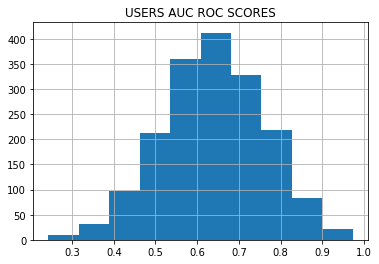

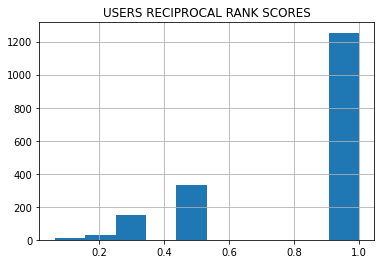

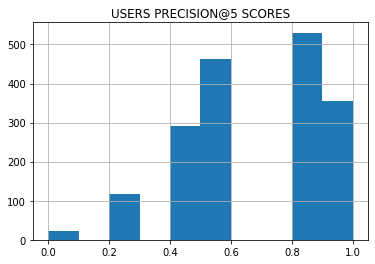

In [ ]:
#####
K = 40
MIN_PROP = 0.25
MAX_PROP = 0.75
#####

print("----------")
print("Cold items data")
print("----------")
_ = two_level_evaluation(lfm_model=lfm_model, 
                         categorizer=categorizer,
                         rec_head=rec_head,
                         data_val=cold_items_data, rec_head_features=features,
                         rec_head_cat_cols=cat_columns,
                         result_cols=result_cols, 
                         lfm_dataset=dataset,
                         n=K, cat_cols_to_change=cat_cols_to_change,
                         user_fe_cols=user_fe_cols,
                         item_fe_cols=item_fe_cols,
                         user_id_column=user_id_column,
                         item_id_column=item_id_column,
                         train_user_weights=user_features,
                         train_item_weights=item_features,
                         min_prop=MIN_PROP, max_prop=MAX_PROP)

### The model with two levels outperforms our single level model, but requires more resources. Let's look at features importances picture.

In [ ]:
X_train_cb_ext = X_train_cb.copy()
X_train_cb_ext["msno"] = data_train_cb["msno"].values
X_train_cb_ext["target"] = data_train_cb["target"].values

In [ ]:
####
#make a sample to plot the shap picture
sample_size = 500
####
sample = test_data_preprocessing(X_train_cb_ext,
                                id="msno", k=20,
                                min_prop=0.25, max_prop=0.75)[features][:sample_size]

In [ ]:
sample.shape

(500, 11)

In [ ]:
sample.head()

,city,gender,bd,registered_via,song_length,genre_ids,artist_name,composer,language,source_type,lfm_score
0,1,nan,0,7,234893.0,458,李玟 (CoCo Lee),Victor劉偉德 /FinLee李華章,3.0,online-playlist,4.376373
1,1,nan,0,7,210128.0,458,周湯豪 (NICKTHEREAL),周湯豪\梁永泰,3.0,album,-1.007358
2,5,male,26,7,223004.0,465,Jessie J,Jessica Cornish| Lukasz Gottwald| Claude Kelly...,52.0,local-library,-1.143737
3,13,male,47,9,252656.0,465,朱俐靜 (Miu Chu),朱俐靜+陳勢安,3.0,local-library,-1.929555
4,1,nan,0,7,197369.0,465,DNCE,Oscar Gorres| Oscar Holter| Joe Jonas| Daryl K...,52.0,listen-with,-1.814270


In [ ]:
explainer = shap.TreeExplainer(rec_head)
shap_values = explainer.shap_values(sample)

In [ ]:
shap.initjs()

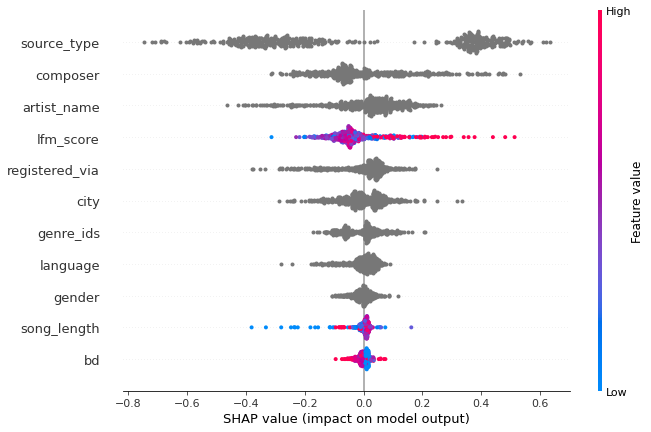

In [ ]:
shap.summary_plot(shap_values, sample, plot_size=(10, 7))

### So, the score from the first level is an important feature.


### Stay tuned! )